# A model of Salt Identification with Keras ConvNet
Transfer learning will probably be harder with the wonky pictures of salt identification.

In [4]:
% matplotlib inline
import datetime as dt

# Import plotting for visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
#from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import numpy as np
import os
import pandas as pd
import pydot
import random
import itertools
import tensorflow as tf
from keras.applications import xception
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers.core import Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm, tqdm_notebook, tnrange
from itertools import chain
import sys
sys.path.append("/utils/DLWorkspace-Utils/keras-multiprocess-image-data-generator/tools")
import image as T

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # for the confusion matrix

import keras.backend as K
K.set_image_data_format('channels_last')

import warnings
import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

## First, let's set up our optimizer so we can choose which one later on.

In [6]:
optimizer_collections = {
    "adadelta" : Adadelta(), 
    "nadam" : Nadam(), 
    "rmsprop": RMSprop(), 
    "adam": Adam(), 
    "adagrad": Adagrad(), 
    "adamax": Adamax(), 
}

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=8, help='Batch size', type=int)
parser.add_argument('--nb_epochs', default=30, help='Number of Epochs', type=int)
parser.add_argument('--optimizer', default='adadelta', help='Optimizer', type=str)
parser.add_argument('--split', default=None, help='Which data set to use', type=int)
parser.add_argument('--decay', default=1e-4, help='Rate decay', type=float)
parser.add_argument('--gpus', default=1, help='Number of GPU', type=int)
parser.add_argument('--drops_epochs', default=0, help='Epochs which rate drop by x10', type=float)
parser.add_argument('--lr', default=0.1, help='Learning Rate', type=float)

args = parser.parse_args("--optimizer adadelta".split())

print( args )
batch_size = 8
if args.batch_size:
    batch_size = args.batch_size

num_gpu = args.gpus
# Number of training epochs
fit_epochs = args.nb_epochs
# data to use. 
split = args.split

lr_top = args.lr

if args.optimizer.startswith("sgd"):
    optimizer = args.optimizer
    opt = SGD(lr = lr_top, decay=args.decay, momentum=0.9, nesterov=True)
else:
    optimizer = args.optimizer
    opt = optimizer_collections[args.optimizer]

Namespace(batch_size=8, decay=0.0001, drops_epochs=0, gpus=1, lr=0.1, nb_epochs=30, optimizer='adadelta', split=None)


### This is a tee object to help write log output.

In [7]:
class Tee(object):
    def __init__(self, name):
        self.file = open(name, "w")
        self.stdout = sys.stdout
        sys.stdout = self
    def __del__(self):
        sys.stdout = self.stdout
        self.file.close()
    def write(self, data):
        self.file.write(data)
        self.stdout.write(data)
    def flush(self):
        self.file.flush()

## Reading in the dataset
First, we locate our data at the correct directories.

In [8]:
data_dir = '/data/kaggle/competitions/tgs-salt-identification-challenge/'
cur_dir = '/work/kaggle-practice/tgs_salt_identification/'
result_dir = os.path.join(cur_dir, 'result')
train_dir = os.path.join(data_dir, 'train')
train_dir_img = os.path.join(train_dir, 'images')
train_dir_mask = os.path.join(train_dir, 'masks')
print(train_dir)
test_dir = os.path.join(data_dir, 'test')
test_dir = os.path.join(test_dir, 'images')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

/data/kaggle/competitions/tgs-salt-identification-challenge/train


Here's a little piece of code if we wanted to test out different lrs and decays
```python
if os.path.isdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay))) == False:
    os.mkdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay)))
    
model_dir = os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay))
```

In [9]:
# Set up location of output
if os.path.isdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s" % (optimizer, batch_size, fit_epochs))) == False:
    os.mkdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s" % (optimizer, batch_size, fit_epochs)))
model_dir = os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s" % (optimizer, batch_size, fit_epochs))
log_file = os.path.join(model_dir, "training_log")
sys.stdout = Tee(log_file)

4000
4000
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
4000
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Some training data examples.


Let's look at some examples of data.

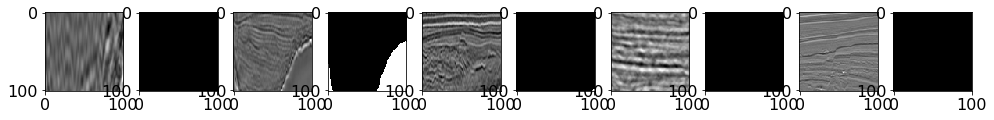

In [12]:

ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = T.load_img(os.path.join(train_dir_img, img_name + '.png'))
    img_mask = T.load_img(os.path.join(train_dir_mask, img_name + '.png'))
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()


### We also need to make some ImageDataGenerators.

In [16]:
train_datagen = T.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="constant",
        cval=0)
train_datagen_unch = T.ImageDataGenerator(rescale=1./255)

### Let's start with the training set.
Here's my original code, before I started using the ImageDataGenerators:
```python
# Get and resize train images and masks
train_x = np.zeros((TRAIN_PICS, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.uint8)
train_y = np.zeros((TRAIN_PICS, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.bool)
count = 0
for file in os.listdir(train_dir_img):
    img = load_img(os.path.join(train_dir_img, file))
    x = img_to_array(img)[:,:,1]
    x = resize(x, (IMAGE_SIZE, IMAGE_SIZE, 1), mode='constant', preserve_range=True)
    train_x[count] = x
    mask = load_img(os.path.join(train_dir_mask, file))
    mask = img_to_array(mask)[:,:,1]
    train_y[count] = resize(mask, (IMAGE_SIZE, IMAGE_SIZE, 1), mode='constant', preserve_range=True)
    count += 1
```

In [17]:
TRAIN_PICS = len(os.listdir(train_dir_img))
print(TRAIN_PICS)
IMAGE_SIZE = 128 # pixel height and width of each image--actual size of the images is 101

train_generator_img_unch = train_datagen_unch.flow_from_directory(
        train_dir_img,
        target_size=(IMAGE_SIZE, IMAGE_SIZE, 1),
        batch_size= batch_size,
        shuffle=False,
        class_mode=None)
train_generator_mask_unch = train_datagen_unch.flow_from_directory(
        train_dir_mask,
        target_size=(IMAGE_SIZE, IMAGE_SIZE, 1),
        batch_size= batch_size,
        shuffle=False,
        class_mode=None)

train_generator_img = train_datagen.flow_from_directory(
        train_dir_img,
        target_size=(IMAGE_SIZE, IMAGE_SIZE, 1),
        batch_size= batch_size,
        shuffle=False,
        class_mode=None)
train_generator_mask = train_datagen.flow_from_directory(
        train_dir_mask,
        target_size=(IMAGE_SIZE, IMAGE_SIZE, 1),
        batch_size= batch_size,
        shuffle=False,
        class_mode=None)

Let's make sure we read it in correctly by visualizing.

In [18]:
'''
ix = random.randint(0, TRAIN_PICS)
print("Index: " + str(ix))
plt.imshow(np.dstack((train_x[ix], train_x[ix], train_x[ix])))
plt.show()
tmp = np.squeeze(train_y[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()
'''

'\nix = random.randint(0, TRAIN_PICS)\nprint("Index: " + str(ix))\nplt.imshow(np.dstack((train_x[ix], train_x[ix], train_x[ix])))\nplt.show()\ntmp = np.squeeze(train_y[ix]).astype(np.float32)\nplt.imshow(np.dstack((tmp, tmp, tmp)))\nplt.show()\n'

In [19]:
print("Some training data examples.")
img_batch, img_unch_batch = next(train_generator_img), next(train_generator_img_unch)
mask_batch, mask_unch_batch = next(train_generator_mask), next(train_generator_mask_unch)
for i in range (0,1):
    image = img_batch[i]
    print("The new image:")
    plt.imshow(image) # .transpose(2,1,0)
    
    image_unch = img_unch_batch[i]
    print("The unchanged image:")
    plt.imshow(image_unch) # .transpose(2,1,0)
    
    mask = mask_batch[i]
    print("The new mask:")
    plt.imshow(mask) # .transpose(2,1,0)
    
    mask_unch = mask_unch_batch[i]
    print("The unchanged mask:")
    plt.imshow(mask_unch) # .transpose(2,1,0)
    
    plt.show()

ZeroDivisionError: integer division or modulo by zero

## Time for the actual model!
For now, I'm basing my model off of Jesper's U-Net model, which is in turn based off of Ketil's model.

### First, an Intersection over Union metric to calculate the accuracy of our identification.
Remember, IoU helps in object detection by figuring out the similarity (intersection/union) of two bounding boxes.

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### And now the model!

In [ ]:
inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [ ]:
# Create the model
saltModel = Model(inputs=[inputs], outputs=[outputs])

In [ ]:
# Compile the model (I'm using Adam optimizer and mean_iou accuracy for now)
saltModel.compile(optimizer=opt, loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
# Let's get a summary of our model just to know what it's doing
saltModel.summary()

In [ ]:
# And we finally fit the model. Notice that we add an early stopper and a check pointer.
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = saltModel.fit(train_x, train_y, validation_split=0.1, batch_size=batch_size, epochs=fit_epochs, 
                    callbacks=[earlystopper, checkpointer])

## And now it is time to test.

### We read in the test set first.

In [ ]:
TEST_PICS = len(os.listdir(test_dir))
test = np.zeros((TEST_PICS, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.uint8)
test_ids = []
sizes_test = []
count = 0
for file in os.listdir(test_dir):
    img = load_img(os.path.join(test_dir, file))
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (IMAGE_SIZE, IMAGE_SIZE, 1), mode='constant', preserve_range=True)
    test[count] = x
    test_ids.append(file) # Images' ids
    count += 1

#### Let's print our test set!

In [ ]:
'''
ix = random.randint(0, TEST_PICS)
print("Index: " + str(ix))
plt.imshow(np.dstack((test[ix], test[ix], test[ix])))
plt.show()
'''

In [ ]:
# Predict on train, val and test
saltModel = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = saltModel.predict(train_x[:int(train_x.shape[0]*0.9)], verbose=1)
preds_val = saltModel.predict(train_x[int(train_x.shape[0]*0.9):], verbose=1)
preds_test = saltModel.predict(test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
'''
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print("Index: " + str(ix))
print("\nOriginal Image:")
plt.imshow(np.dstack((train_x[ix], train_x[ix], train_x[ix])))
plt.show()
print("\nExpected Mask:")
tmp = np.squeeze(train_y[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()
print("\nActual Mask:")
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()
'''

## Lastly, we prepare the submission.

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

sub.to_csv(os.path.join(model_dir, 'saltSubmission.csv'))

print('Prediction result saved as saltSubmission.csv')